In [1]:
!pip install pandas
!pip install numpy
!pip install scipy
!pip install sklearn
!pip install matplotlib
!pip install Pillow

import PIL
import pylab
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt


/Users/kaviarajesh/Downloads/lunasf/landsat/training/unhealthy/.DS_Store
/Users/kaviarajesh/Downloads/lunasf/landsat/training/healthy/.DS_Store
Found 138 files belonging to 2 classes.
Using 111 files for training.
Found 138 files belonging to 2 classes.
Using 13 files for validation.


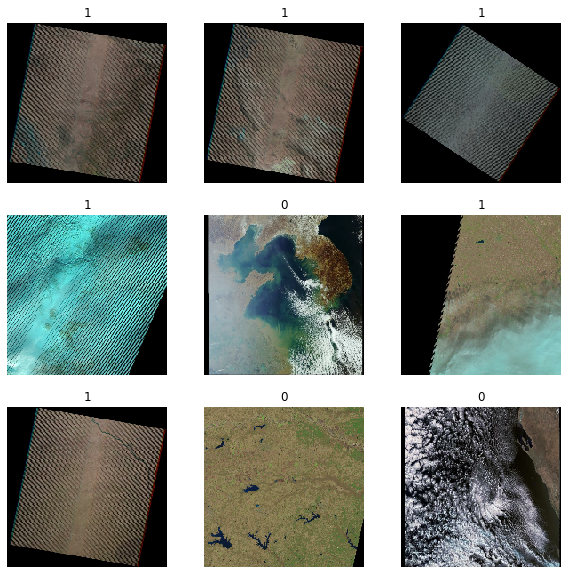

In [2]:
import os

img_dir = "/Users/kaviarajesh/Downloads/lunasf/landsat/training"
#85 unhealthy and 85 healthy 

num_skipped = 0
for folder_name in ("unhealthy", "healthy"):
    folder_path = os.path.join(img_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            print(fpath)


image_size = (180, 180)
batch_size = 159

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    img_dir,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    img_dir,
    validation_split=0.1,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
        
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)


inputs = tf.keras.Input(shape=image_size)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [3]:
def make_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return tf.keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [4]:
#with 80 images each:
#epochs= 10 accuracy 45.45%
#epochs = 50 accuracy 61.29%

epochs = 50

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, validation_data=val_ds,
)

Epoch 1/50
1/1 [==============================] - 30s 30s/step - loss: 0.6426 - accuracy: 0.6216 - val_loss: 0.6921 - val_accuracy: 0.6923
Epoch 2/50
1/1 [==============================] - 22s 22s/step - loss: 0.6673 - accuracy: 0.8198 - val_loss: 0.6923 - val_accuracy: 0.7692
Epoch 3/50
1/1 [==============================] - 24s 24s/step - loss: 0.3526 - accuracy: 0.8559 - val_loss: 0.6922 - val_accuracy: 0.6923
Epoch 4/50
1/1 [==============================] - 32s 32s/step - loss: 0.1956 - accuracy: 0.9459 - val_loss: 0.6918 - val_accuracy: 0.6154
Epoch 5/50
1/1 [==============================] - 38s 38s/step - loss: 0.2035 - accuracy: 0.9009 - val_loss: 0.6914 - val_accuracy: 0.6154
Epoch 6/50
1/1 [==============================] - 36s 36s/step - loss: 0.1295 - accuracy: 0.9550 - val_loss: 0.6913 - val_accuracy: 0.6154
Epoch 7/50
1/1 [==============================] - 35s 35s/step - loss: 0.0899 - accuracy: 0.9730 - val_loss: 0.6910 - val_accuracy: 0.6154
Epoch 8/50
1/1 [===========

In [6]:
img = tf.keras.preprocessing.image.load_img(
    "/Users/kaviarajesh/Downloads/lunasf/landsat/training/test.jpeg", target_size=image_size
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent healthy and %.2f percent unhealthy."
    % (100 * (1 - score), 100 * score)
)

#test.jpeg 12.17 healthy 87.83 unhealthy
#test2 .jpg

This image is 32.06 percent healthy and 67.94 percent unhealthy.
